In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [74]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


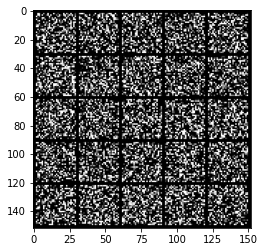

In [75]:
#checking the show_tensor_images function
tensor = torch.randn((25,28,28))
show_tensor_images(tensor)

In [14]:
def get_noise(n_samples,z_dim):
  '''
  Function to get random noise vector.
  creates a tensor of shape(batch,Z-dim) filled with random numbers from the normal distribution.
  Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
  ''' 

  return torch.randn(n_samples,z_dim, device=device)

In [16]:
def get_generator_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
  '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)

        ConvTranspose2d---> Generally for upsampling
  '''
  if not final_layer:
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.ReLU()
        
    )
  else: 
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.Tanh()
    )

In [40]:
class Generator(nn.Module):
  def __init__(self,z_dim=10, im_chan=1, hidden_dim=64):
    super().__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        get_generator_block(z_dim, hidden_dim * 4),
        get_generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
        get_generator_block(hidden_dim * 2, hidden_dim),
        get_generator_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
    )

  def unsqueeze_noise(self, noise):
    '''
    Given a noise tensor,returns a copy of that noise with width and height = 1 and channels = z_dim.
    Parameters:
        noise: a noise tensor with dimensions (n_samples, z_dim)
    '''
    return noise.view(len(noise), self.z_dim, 1, 1)
  
  def forward(self, noise):
    
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

In [46]:
def get_discriminator_block(input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
  '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
  '''

  if not final_layer:
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.LeakyReLU(0.2)
    )
  else: 
    return nn.Sequential(
      nn.Conv2d(input_channels, output_channels, kernel_size, stride)
    )

In [60]:
class Discriminator(nn.Module):
  def __init__(self,im_chan=1, hidden_dim=16,batch_size = 32):
    super().__init__()
    self.batch_size = batch_size
    self.disc = nn.Sequential(
        get_discriminator_block(im_chan, hidden_dim),
        get_discriminator_block(hidden_dim, hidden_dim * 2),
        get_discriminator_block(hidden_dim * 2, 1, final_layer=True),
    )

  def forward(self,image):
    return self.disc(image).view(self.batch_size, -1)

In [56]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [79]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 32
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [84]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

In [85]:
#Initializing Weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [86]:
def get_generator_loss(gen, disc, num_images, z_dim):
  '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
  noise = get_noise(num_images,z_dim)
  g_z = gen(noise)
  d_out = disc(g_z)
  gen_loss = criterion(d_out,torch.ones_like(d_out))
  return gen_loss

In [87]:
def get_discriminator_loss(gen, disc, real, num_images, z_dim):
  '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
  noise = get_noise(num_images,z_dim)
  g_z = gen(noise)
  d_out = disc(g_z.detach())

  fake_loss = criterion(d_out, torch.zeros_like(d_out)) 
  real_loss = criterion(disc(real),torch.ones_like(d_out))

  return (fake_loss + real_loss)/2

  0%|          | 0/1875 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch0: Step 500: Generator loss: 0.8796636613607408, discriminator loss: 0.5757072506546971


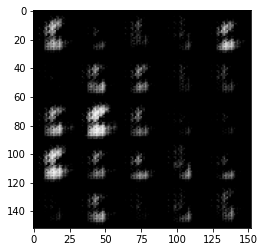

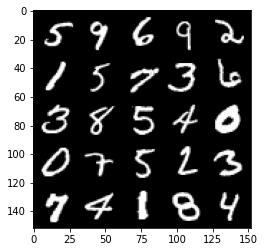

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch0: Step 1000: Generator loss: 1.027296854615211, discriminator loss: 0.5729408934712416


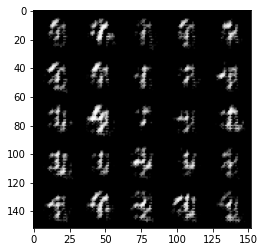

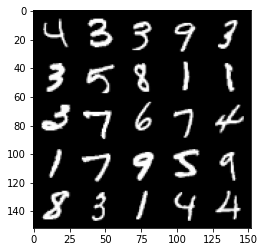

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch0: Step 1500: Generator loss: 0.8580423467159267, discriminator loss: 0.6157373687028886


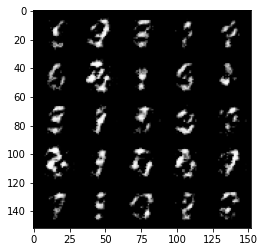

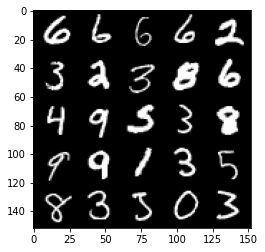

  0%|          | 0/1875 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch1: Step 2000: Generator loss: 0.942621499896049, discriminator loss: 0.5507794232964515


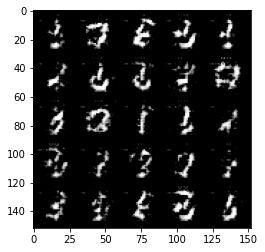

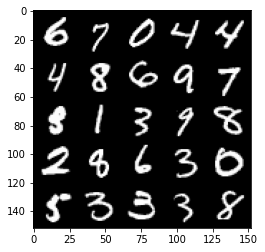

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch1: Step 2500: Generator loss: 1.0609440340399736, discriminator loss: 0.5221995736956595


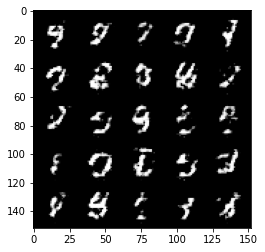

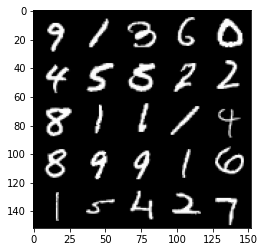

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch1: Step 3000: Generator loss: 1.0933286963105215, discriminator loss: 0.516270599246025


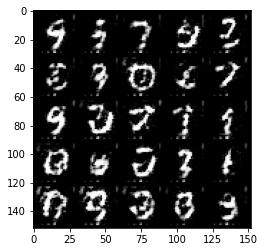

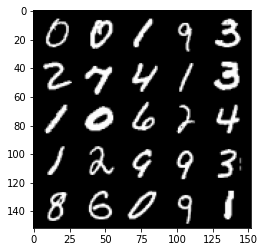

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch1: Step 3500: Generator loss: 0.9507710021734227, discriminator loss: 0.551847862064839


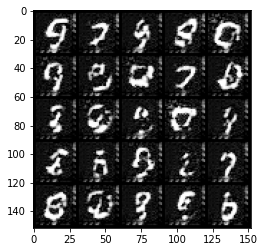

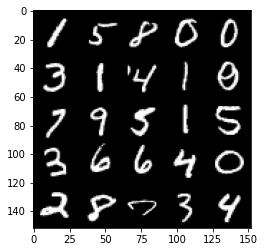

  0%|          | 0/1875 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch2: Step 4000: Generator loss: 0.9382341452836991, discriminator loss: 0.5603134393692017


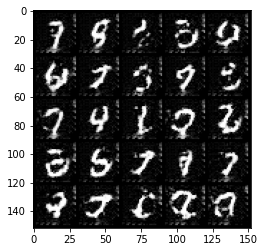

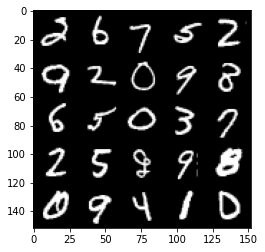

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch2: Step 4500: Generator loss: 0.9130257492661477, discriminator loss: 0.5781599771380425


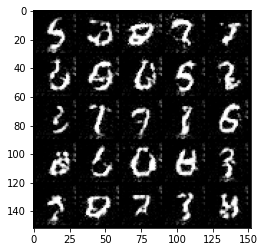

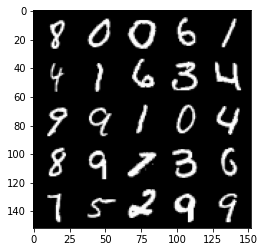

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch2: Step 5000: Generator loss: 0.8991201746463774, discriminator loss: 0.5908854555487637


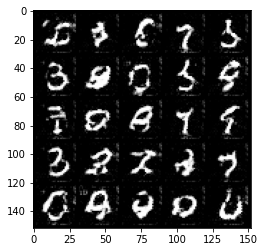

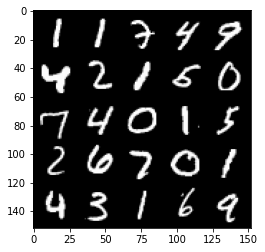

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch2: Step 5500: Generator loss: 0.8727932209968565, discriminator loss: 0.6125178476572037


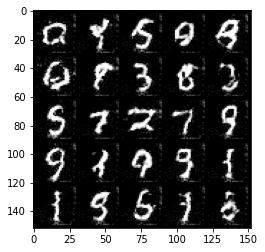

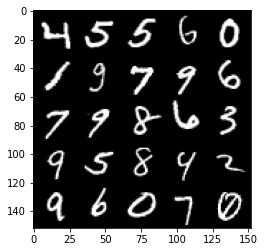

  0%|          | 0/1875 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch3: Step 6000: Generator loss: 0.8323995894193654, discriminator loss: 0.6341271063089373


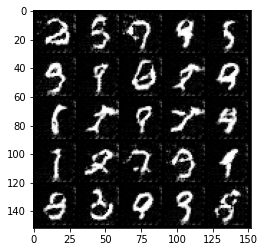

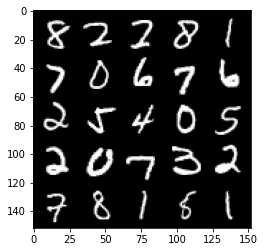

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch3: Step 6500: Generator loss: 0.8040764692425721, discriminator loss: 0.6469175884723661


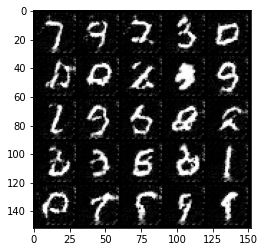

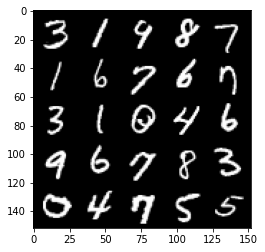

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch3: Step 7000: Generator loss: 0.7864369660615912, discriminator loss: 0.6584391388893123


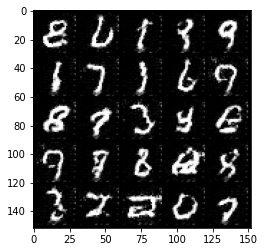

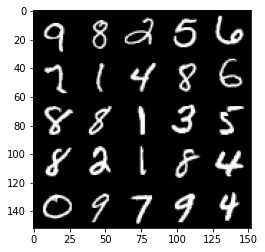

  0%|          | 0/1875 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch4: Step 7500: Generator loss: 0.773665852546692, discriminator loss: 0.6650456086397178


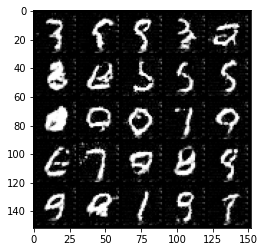

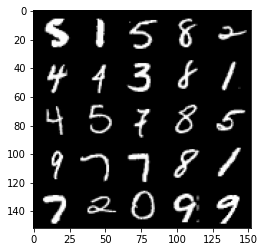

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch4: Step 8000: Generator loss: 0.7615897414684297, discriminator loss: 0.6753075728416444


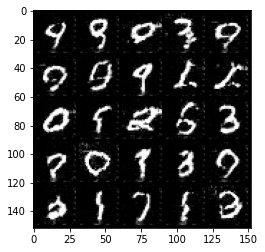

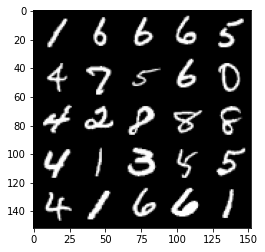

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch4: Step 8500: Generator loss: 0.7465836983919139, discriminator loss: 0.6848297249078759


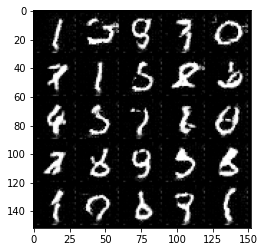

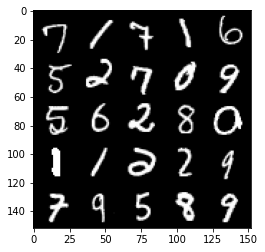

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch4: Step 9000: Generator loss: 0.7470084114074711, discriminator loss: 0.6833911592960359


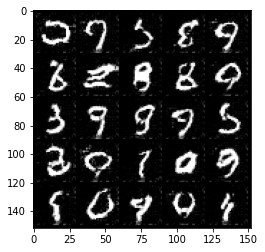

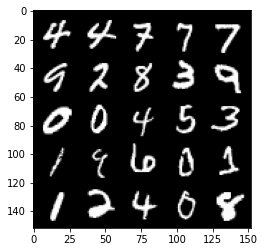

  0%|          | 0/1875 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch5: Step 9500: Generator loss: 0.7384006851911542, discriminator loss: 0.6876541696786881


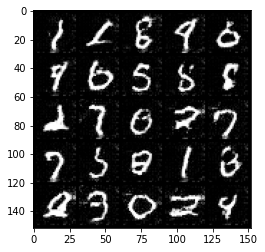

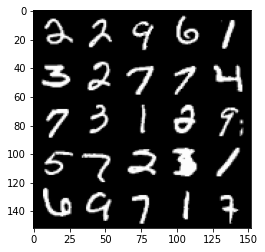

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch5: Step 10000: Generator loss: 0.7356765825748438, discriminator loss: 0.6880608570575711


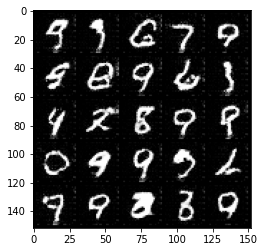

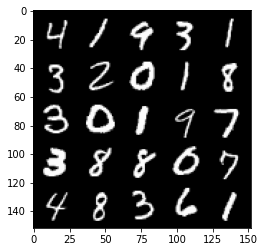

In [ ]:
mean_generator_loss = 0
mean_discriminator_loss = 0
cur_step = 0
n_epochs = 50
for epoch in range(n_epochs):
  for real,_ in tqdm(dataloader):
  
    #For Discriminator
    disc_opt.zero_grad()
    disc_loss = get_discriminator_loss(gen, disc, real, batch_size, z_dim)
    disc_loss.backward(retain_graph = True)
    disc_opt.step()

    #For Generator
    gen_opt.zero_grad()
    gen_loss = get_generator_loss(gen, disc, batch_size, z_dim)
    gen_loss.backward()
    gen_opt.step()

    mean_discriminator_loss += disc_loss.item() / display_step
    mean_generator_loss += gen_loss.item() / display_step

    if cur_step % display_step == 0 and cur_step > 0:
      print(f"Epoch{epoch}: Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
      fake_noise = get_noise(batch_size, z_dim)
      fake = gen(fake_noise)
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0
    
    cur_step += 1